In [1]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.python.keras import backend as K
from keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D

#Resnet-50 has been pre_trained, weights have been saved in below path
resnet_weights_path = 'ResNet-50'
vgg16_weights_path="VGG-16"

In [2]:
#Display the dir list
print(os.listdir("C:\\Users\\THASWIKA AIRA\\Desktop\\final"))

   # C:\\Users\\THASWIKA AIRA\\Documents\\DL\\project\\CNN_assignment

['.ipynb_checkpoints', 'data', 'FINAL.ipynb', 'Presentation1.pptx', 'ResNet-50', 'Skin Cancer.ipynb', 'skin_resnet', 'skin_resnet_new.h5', 'VGG-16', '~$Presentation1.pptx']


In [3]:
def Dataset_loader(DIR,RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG

benign_train = np.array(Dataset_loader('data\\test\\benign',224))
malign_train = np.array(Dataset_loader('data\\train\\malignant',224))
benign_test = np.array(Dataset_loader('C:\\Users\\THASWIKA AIRA\\Desktop\\final\\data\\test\\benign',224))
malign_test = np.array(Dataset_loader('C:\\Users\\THASWIKA AIRA\\Desktop\\final\\data\\test\\malignant',224))


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 269.56it/s]


In [4]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Split validation data from train data
# x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.33,random_state=42)
x_train=X_train[1000:]
x_val=X_train[:1000]
y_train=Y_train[1000:]
y_val=Y_train[:1000]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

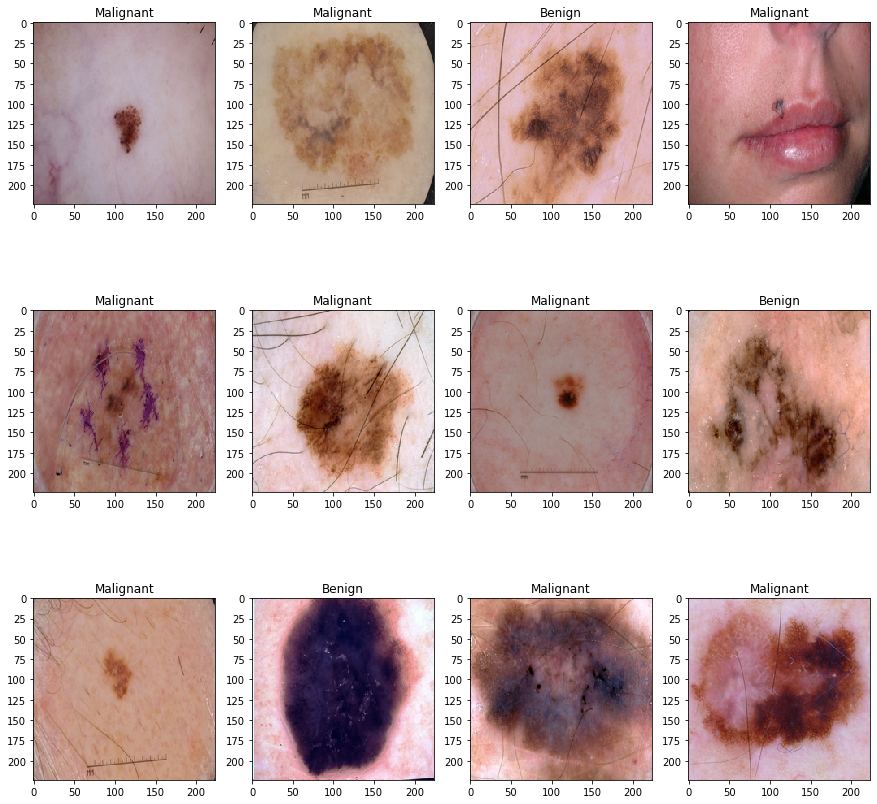

In [5]:
#Display first 12 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [6]:
# Data auguments
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# datagen.fit(x_train)

RESNET


In [7]:
model = Sequential()
model.add(ResNet50(include_top=False, input_tensor=None, input_shape=(224,224,3), pooling='avg', classes=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [8]:
# Compile model
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

D:\PYTHON\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.7)

In [10]:
# Train model
batch_size=64
epochs=10
History = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),validation_data=(x_val,y_val),epochs= 15, steps_per_epoch=x_train.shape[0])
                            

D:\PYTHON\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
8/8 [==============================] - 137s 18s/step - loss: 0.8694 - accuracy: 0.5112 - val_loss: 0.8363 - val_accuracy: 0.2330
Epoch 2/15
8/8 [==============================] - 185s 25s/step - loss: 0.8224 - accuracy: 0.5375 - val_loss: 0.6987 - val_accuracy: 0.3320
Epoch 3/15
8/8 [==============================] - 210s 28s/step - loss: 0.7224 - accuracy: 0.5923 - val_loss: 0.6323 - val_accuracy: 0.7670
Epoch 4/15
8/8 [==============================] - 214s 29s/step - loss: 0.7077 - accuracy: 0.6247 - val_loss: 0.6063 - val_accuracy: 0.7670
Epoch 5/15
8/8 [==============================] - 336s 46s/step - loss: 0.6463 - accuracy: 0.6552 - val_loss: 0.5960 - val_accuracy: 0.7670
Epoch 6/15
8/8 [==============================] - 209s 28s/step - loss: 0.6586 - accuracy: 0.6511 - val_loss: 0.5589 - val_accuracy: 0.7670
Epoch 7/15
8/8 [==============================] - 227s 31s/step - loss: 0.6941 - accuracy: 0.6445 - val_loss: 0.5366 - val_accuracy: 0.7670
Epoch 8/15
8/8 [====

In [ ]:
# Testing model on test data to evaluate
lists=[]
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i][0]>0.5:
        lists.append(1)
    else:
        lists.append(0)
        
print(accuracy_score(Y_test, lists))

In [12]:
model.save('skin_resnet')

D:\PYTHON\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: skin_resnet\assets


In [13]:
model.save('skin_resnet_new.h5')

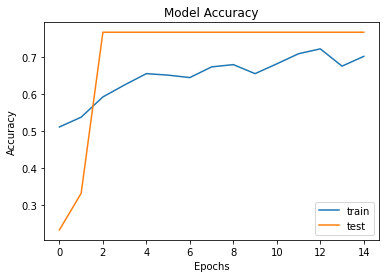

In [14]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [15]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(Y_test[i]==lists[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not Y_test[i]==lists[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

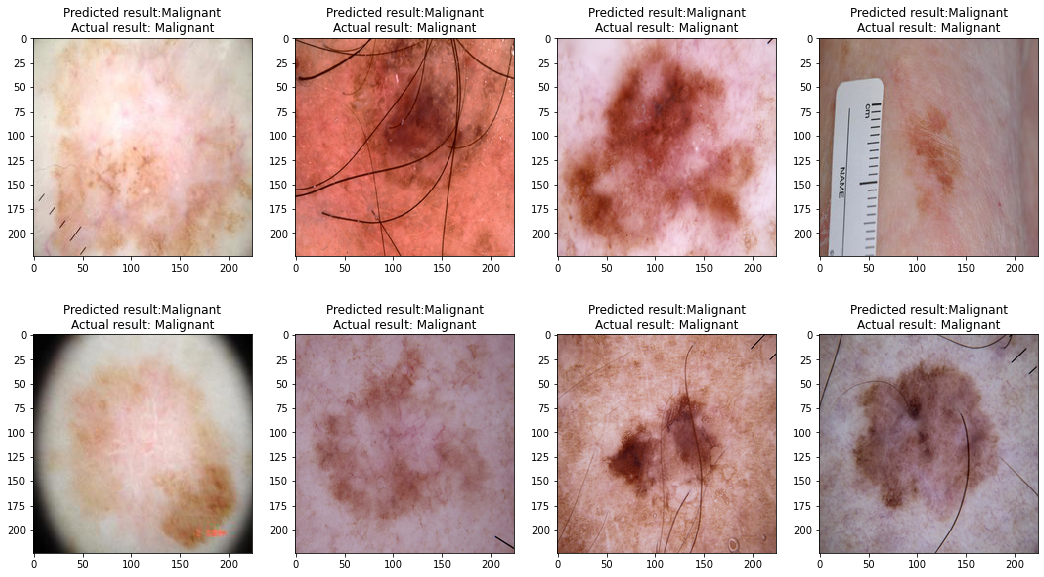

In [16]:
# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(lists[prop_class[i]])
                       +"\n"+"Actual result: "+ Transfername(Y_test[prop_class[i]]))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()